In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from datasets import PascalVOC
from utils import scale_bbs, plot_with_bbs, show_img
from vgg import vggfeats

from roi_pooling import rpn_to_roi, roi_pooling, calc_iou
from region_proposal import calculate_rpn_targets, RegionProposalNetwork

In [2]:
path =  '/home/austin/data/VOC/VOC2007/'


In [3]:
trans = transforms.Compose([transforms.Scale(600),
                            transforms.ToTensor()])

In [4]:
voc = PascalVOC(root=path+'JPEGImages', annFile=path+"pascal_train2007.json", transform=trans)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [5]:
classes = voc.classes

In [6]:
test_idx = 1

In [7]:
img, target = voc[test_idx]

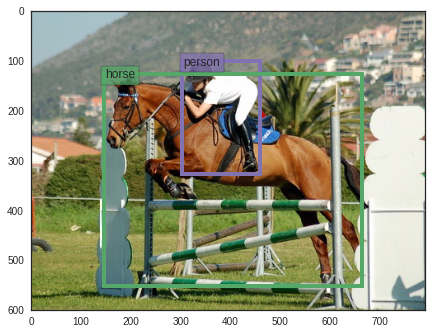

In [8]:
plot_with_bbs(img, target, classes)

## Generate Anchors
- (Multi-Scale Anchors as Regression References)

In [9]:
rpn_cls, rpn_regr = calculate_rpn_targets(img, target)
num_anchors = rpn_cls.shape[1]

## Generate VGG Features

In [10]:
img_features = vggfeats(Variable(img.unsqueeze(0)))

In [11]:
rpn_cls.shape[1]

18

## Features and Anchors through RPN to get region proposals

In [12]:
rpn = RegionProposalNetwork(num_anchors=rpn_cls.shape[1])

In [13]:
probs, regions, img_features = rpn(img_features)

## Transform proposals to (300, 4) bounding box coordinates (x,y, h, w)

In [14]:
regions.size(), probs.size(), img_features.size()

(torch.Size([1, 72, 18, 24]),
 torch.Size([1, 18, 18, 24]),
 torch.Size([1, 512, 18, 24]))

In [15]:
R = rpn_to_roi(probs, regions) # check out these warnings.

operands could not be broadcast together with shapes (72,18) (18,18) 
operands could not be broadcast together with shapes (72,18) (18,18) 
operands could not be broadcast together with shapes (72,18) (18,18) 
operands could not be broadcast together with shapes (72,18) (18,18) 
operands could not be broadcast together with shapes (72,18) (18,18) 
operands could not be broadcast together with shapes (72,18) (18,18) 
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


In [16]:
R.shape

(300, 4)

## Calculate IOU between proposals and target boxes
- if no boxes make it through this thresholding, go to next image

In [17]:
from roi_pooling import calc_iou

In [18]:
X2, Y1, Y2, IouS = calc_iou(R, target, classes)


In [19]:
target

[{'area': 13110,
  'bbox': [303, 100, 156, 227],
  'category_id': 15,
  'height': 364,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'width': 480},
 {'area': 81326,
  'bbox': [146, 126, 517, 426],
  'category_id': 13,
  'id': 3,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]]}]

In [20]:
X2.shape, Y1.shape, Y2.shape, IouS

((1, 58, 4),
 (1, 58, 21),
 (1, 58, 160),
 [0.1271860093367472,
  0.1029748281396457,
  0.14645308890971834,
  0.1389961387278067,
  0.14260249528947863,
  0.13071895403477296,
  0.1258426963464209,
  0.1344537812866323,
  0.12814645279600353,
  0.1029748281396457,
  0.16359918166953133,
  0.1258426963464209,
  0.111999999776,
  0.10147991521885853,
  0.10983981668228875,
  0.1341719074755306,
  0.10067114071438224,
  0.12981744395574554,
  0.14260249528947863,
  0.1029748281396457,
  0.1720430103827032,
  0.14028056084112112,
  0.15655577268775778,
  0.11787819230279334,
  0.1029748281396457,
  0.1552106426713733,
  0.11036036011180099,
  0.1257367384563129,
  0.1271860093367472,
  0.11070110680682453,
  0.13363028923467643,
  0.1438202243959096,
  0.1766004411112573,
  0.10067114071438224,
  0.11312217168976885,
  0.14645308890971834,
  0.1388286331044932,
  0.10596026466675439,
  0.16427104689061386,
  0.1041214748283699,
  0.1328273242261341,
  0.14842300529049535,
  0.141093474177

## Sample(filter) RIOS from 300 to ~32
- Check how many boxes predicted "background" class
- Try to select half ROI from positive samples and half from negative samples (background)

In [21]:
neg_samples = np.where(Y1[0, :, 0] == 1) # boxes where the model predicted background (20)
pos_samples = np.where(Y1[0, :, 0] == 0) # boxes containing a class
neg_samples = neg_samples[0]
pos_samples = pos_samples[0]

In [22]:
num_rois = 32

In [23]:

if len(pos_samples) < num_rois // 2:
    selected_pos_samples = pos_samples.tolist()
else:
    selected_pos_samples = np.random.choice(pos_samples, num_rois // 2, replace=False).tolist()
try:
    selected_neg_samples = np.random.choice(neg_samples, num_rois - len(selected_pos_samples),
                                            replace=False).tolist()
except:
    selected_neg_samples = np.random.choice(neg_samples, num_rois - len(selected_pos_samples),
                                            replace=True).tolist()

sel_samples = selected_pos_samples + selected_neg_samples


## ROIpool the selected rois
- input img, roi output --> (1, num_rois, channels, 7, 7) or (1, 32, 3, 7, 7) small images for us to classify


In [24]:
rois = roi_pooling(img_features, R[sel_samples])

In [25]:
rois.size()

torch.Size([32, 512, 7, 7])

In [26]:
from frcnn import Classifier

In [27]:
classifier = Classifier()

## Final Classifier
- flatten and apply classification + regress each roi(no regression target for background class). (TimeDistributed in keras)

In [28]:
out_class, out_regr = classifier(rois)

In [31]:
out_class.size(), out_regr.size() # predictions for our 32 rois

(torch.Size([32, 21]), torch.Size([32, 80]))

In [32]:
out_class[0]

Variable containing:
-0.0339
-0.1339
 0.0380
 0.0573
 0.0050
-0.0425
 0.0180
 0.1224
-0.1390
-0.2095
 0.1131
 0.0220
-0.1349
 0.0142
-0.0417
 0.1125
 0.0093
-0.1317
-0.1287
-0.0615
-0.2044
[torch.FloatTensor of size 21]

In [34]:
out_regr[0]

Variable containing:
-0.2501
-0.1597
 0.0235
 0.0288
 0.1246
-0.0206
 0.0506
 0.0478
-0.0865
 0.1566
-0.0930
-0.0484
 0.1236
-0.0569
 0.1032
 0.0738
 0.0392
 0.0017
-0.1432
-0.1115
-0.0935
 0.0365
 0.0385
 0.0571
 0.0005
-0.0040
-0.1857
 0.2385
 0.1127
-0.0437
-0.0144
-0.0168
 0.0036
 0.0227
 0.0724
-0.0119
 0.0292
 0.0004
-0.1480
-0.0309
 0.0221
 0.1509
-0.0528
-0.0847
 0.0540
-0.0735
 0.0741
-0.1047
-0.0538
 0.2881
 0.1511
 0.2206
 0.0461
-0.1493
-0.0920
-0.0010
-0.0368
 0.0753
 0.0874
 0.0704
-0.1293
-0.0904
-0.1025
-0.0227
 0.0467
-0.0547
-0.1200
-0.0133
 0.0477
-0.0362
 0.0501
-0.0775
 0.1062
 0.0799
 0.0905
 0.0666
-0.0574
 0.0602
 0.0142
 0.0249
[torch.FloatTensor of size 80]